In [ ]:
# Example-2-GP-BS-Derivatives
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

# Overview
The purpose of this notebook is to demonstrate the derivation of the greeks in a Gaussian Process Regression model (GP), fitted to option price data. 

In this notebook, European option prices are generated from the Black-Scholes model.  The notebook begins by building a GP call model, where the input is the underlying price. The delta is then derived and compared with the Black-Scholes (BS)
delta. The exercise is repeated, but using the volatility as the input instead of the underlying price. The vega of the GP is then derived and compared with the BS vega.


In [4]:
from random import Random
from numpy import *
from time import *
from datetime import *
from BlackScholes import *
import math
import scipy as sp

import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Black-Scholes model parameters

In [5]:
KC = 130
KP = 70
r = 0.002
sigma = 0.4
T = 2.0
S0 = 100

In [6]:
lb = 0
ub = 300
training_number = 100
testing_number = 50
sigma_n = 1e-8 # additive noise in GP

call = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[0]
put = lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, T, y, 0)[0]

# delta

In [7]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime = np.dot(k_s_prime, alpha_p)/(ub-lb)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([97.69100952]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([465.75056458]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [8]:
delta = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[1]
delta(x_test, sigma) - f_prime

array([[ 4.68427440e-04],
       [-1.31777381e-04],
       [-5.25008042e-05],
       [ 6.31628975e-05],
       [ 1.09879739e-05],
       [-4.79259682e-05],
       [-7.22850161e-05],
       [-1.13789956e-05],
       [-5.21614757e-07],
       [-2.29740840e-05],
       [-5.51234391e-05],
       [ 8.78776343e-06],
       [-5.05119615e-05],
       [-1.11084205e-05],
       [-6.02478629e-07],
       [-5.05385519e-06],
       [-2.76927700e-06],
       [ 9.06300367e-06],
       [ 2.77805855e-05],
       [ 4.09626383e-05],
       [ 4.27037123e-05],
       [ 3.70658488e-05],
       [ 3.44600473e-05],
       [ 4.02434892e-05],
       [ 4.50363477e-05],
       [ 4.49495120e-05],
       [ 2.88051413e-05],
       [ 3.21271604e-06],
       [-1.98413565e-05],
       [-3.11572716e-05],
       [-3.61573024e-05],
       [-4.98646386e-05],
       [-8.36707125e-05],
       [-1.33514526e-04],
       [-1.77742456e-04],
       [-1.97553459e-04],
       [-1.90425183e-04],
       [-1.74336502e-04],
       [-1.7

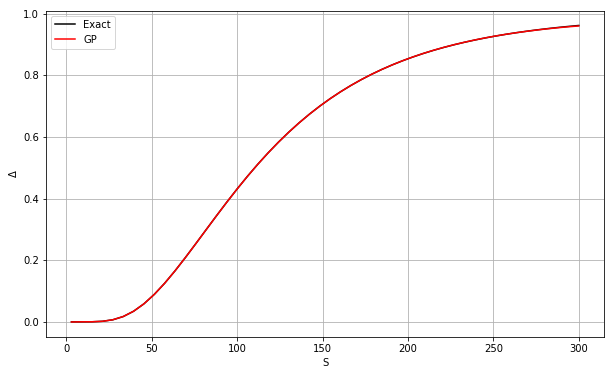

In [9]:
# compare the GP delta with the BS delta
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10})

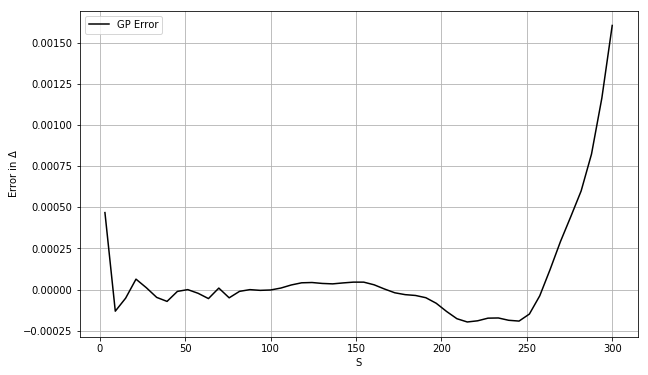

In [11]:
# Show the error between the GP delta and the BS delta
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma) - f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('Error in $\Delta$')
plt.legend(loc = 'best', prop={'size':10})

## vega

In [13]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train[idx]))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime = np.dot(k_s_prime, alpha_p)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-27.68511581]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-28.32736921]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [14]:
vega = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[2]
vega((S0-lb)/(ub-lb), x_test) - f_prime

array([[-0.00975357],
       [-0.057116  ],
       [ 0.04746548],
       [-0.02211377],
       [ 0.0282971 ],
       [-0.07521463],
       [-0.01195535],
       [-0.01490392],
       [-0.03180528],
       [ 0.01629947],
       [ 0.00772117],
       [ 0.02249493],
       [ 0.00348173],
       [ 0.02394678],
       [ 0.00384827],
       [ 0.00610841],
       [ 0.00023761],
       [-0.00010175],
       [ 0.00209765],
       [ 0.00125911],
       [ 0.00030588],
       [-0.00213746],
       [ 0.00153769],
       [ 0.00207812],
       [ 0.00185779],
       [ 0.0051291 ],
       [ 0.00393473],
       [ 0.00415837],
       [ 0.00237801],
       [-0.00228365],
       [-0.00374009],
       [-0.00708891],
       [-0.00781503],
       [-0.0083757 ],
       [-0.00476461],
       [-0.00461401],
       [-0.00084656],
       [ 0.00225347],
       [ 0.00140709],
       [ 0.0056136 ],
       [ 0.00176173],
       [-0.00691334],
       [-0.02528516],
       [-0.03347402],
       [-0.0528138 ],
       [-0

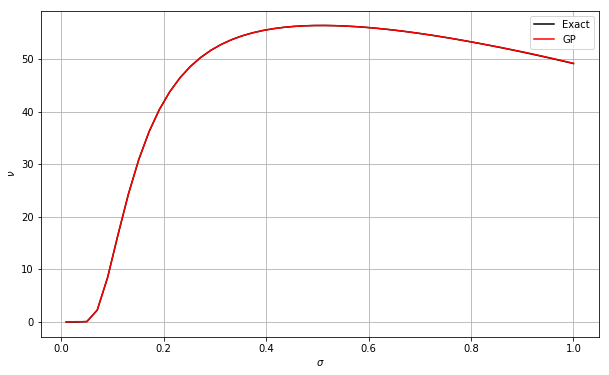

In [15]:
# Compare the GP vega with the BS vega
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test), color = 'black', label = 'Exact')
plt.plot(x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('$\\nu$')
plt.legend(loc = 'best', prop={'size':10})

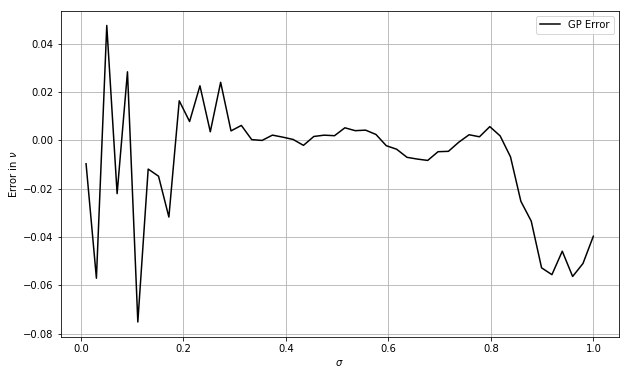

In [16]:
# compute the error between the GP vega and the BS vega
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test)-f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('Error in $\\nu$')
plt.legend(loc = 'best', prop={'size':10})